In [128]:
## load pkg
from landlab.components.uniform_precip import PrecipitationDistribution
import numpy as np
import random
import matplotlib.pyplot as plt
from landlab.components import SoilInfiltrationGreenAmpt
from landlab.components.overland_flow import OverlandFlow
from landlab.plot.imshow import imshow_grid
from landlab import imshow_grid_at_node                                                                                                                               
from landlab.components import OverlandFlow
import matplotlib.colors as mcolors
from landlab.io import read_esri_ascii



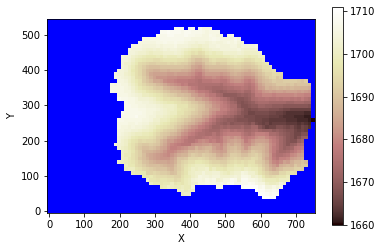

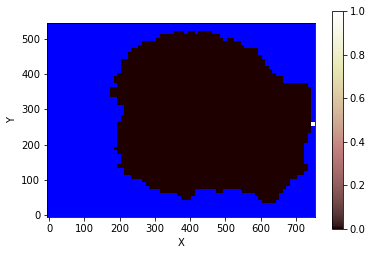

In [129]:
## Load grid
fname = 'hugo_site.asc'
mg, z = read_esri_ascii(fname, name='topographic__elevation')
mg.status_at_node[mg.nodes_at_right_edge] = mg.BC_NODE_IS_FIXED_VALUE
mg.status_at_node[np.isclose(z, -9999.)] = mg.BC_NODE_IS_CLOSED
mg.set_watershed_boundary_condition('topographic__elevation')

## Show basin topography
fig = plt.subplots()
imshow_grid(mg, z)

## Show boundries condition of the basin
fig = plt.subplots()
imshow_grid(mg, mg.status_at_node, color_for_closed="blue")

In [130]:
## Defiend param for the generator
mean_duration = 6 ## hours, storm duration
mean_inter_duration = 20 ## hour,  duration between storms
mean_depth = 20   ## mm
total_time  = 24*30 ## 24 hours * 30 days
delta_t = 1; ## hour
np.random.seed(np.arange(10))

# Initialize generator
precip = PrecipitationDistribution(mg, mean_storm_duration=mean_duration, mean_interstorm_duration=mean_inter_duration, mean_storm_depth=mean_depth, total_t=total_time,delta_t=delta_t)
n = random.randint(1,101) ## random seed number 
precip.seed_generator(seedval=n)


In [131]:
## Iterating on all of the storms and save rainfall data

# Arrays for saving the outputs.
storm_dts = []
interstorm_dts = []
intensities = []
depths  = [] 
total_time=0
time_vec =[0]
rain_vec = [0]
for (storm_dt, interstorm_dt) in precip.yield_storms():
        ## Save rainfall data

    storm_dts.append(np.array(storm_dt)) ## hours
    interstorm_dts.append(interstorm_dt) ## hours
    intensities.append(mg.at_grid['rainfall__flux']) ## mm/h
    depths.append(mg.at_grid['rainfall__flux']*storm_dt)
    ## Creating rainfall time-series
    total_time += 1
    time_vec.append(total_time)
    rain_vec.append(intensities[-1])
    total_time += storm_dt
    time_vec.append(total_time)
    rain_vec.append(intensities[-1])
    total_time += 1
    time_vec.append(total_time)
    rain_vec.append(0)
    total_time += interstorm_dt
    time_vec.append(total_time)
    rain_vec.append(0)

time_vec = np.asanyarray(time_vec)*60 ##in minutes
rain_vec = np.asanyarray(rain_vec)

C:\Users\yuvals\AppData\Local\Continuum\anaconda3\Lib\site-packages\ipykernel_launcher.py:23: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.


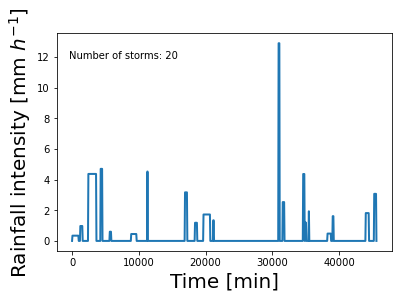

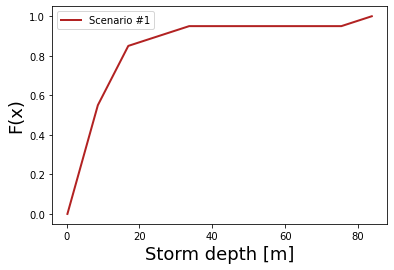

In [132]:
## Plotting the full rainfall series
fig,ax = plt.subplots()
number_of_storms = str(len(storm_dts))
ax.plot(time_vec,rain_vec,linewidth=2)   
plt.xlabel('Time [min]',fontsize=20)
plt.ylabel('Rainfall intensity [mm $h^{-1}]$',fontsize=20)
plt.text(0.2, 0.9,'Number of storms: ' + number_of_storms, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
## 

############### If seaborn pkg is installed!!!!! ###############3
## Plotting kernel density of storm duration
# figure ,ax = plt.subplots()
# ax = sns.kdeplot(intensities,color='blue')
# ax = sns.kdeplot(intensities,color = 'r')
# #plt.hist(storm_dts)
# plt.xlabel('Storm duration [min]')
# plt.ylabel('Density')
# plt.legend()
# ##

## Plotting rainstorm depth CDF-plot
figure ,ax = plt.subplots()
hist, bin_edges = np.histogram(depths, normed=True)
b = [0]
b.extend(np.cumsum(hist)/np.sum(hist))
plt.plot(bin_edges,b,label='Scenario #1',linewidth=2,color='firebrick')
plt.xlabel('Storm depth [m]',fontsize=18)
plt.ylabel('F(x)',fontsize=18)
ax.legend()
##


In [133]:
## Create model components fields
## Inflitration component
hydraulic_conductivity = mg.ones('node')* 1.0E-5
d = mg.add_ones("soil_water_infiltration__depth", at="node", dtype=float)
d = mg.at_node['soil_water_infiltration__depth']
d *= 0.2

## Surface water
mg.add_zeros('surface_water__depth',at='node')  # a veneer of water  the model
h = mg.at_node['surface_water__depth']
h += 0.0001


## Initialization
SI = SoilInfiltrationGreenAmpt(mg,hydraulic_conductivity=hydraulic_conductivity)
of = OverlandFlow(mg, steep_slopes=True)


In [134]:

## Change storm times to minutes
interstorm_dts_min = np.asanyarray(interstorm_dts)*60 ## in minutes
storm_dts_min = np.asanyarray(storm_dts)*60 ## in minutes
global_time = np.sum(interstorm_dts_min) + np.sum(storm_dts_min)


## Arrays for saving inputs and counters
SI_mean_vec = []
outlet_depth = []
outlet_times = []
elapsed_time = 0
node_of_max_q = 2126

## Better color map for plotting overlandflow
colors = [(0,0.2,1,i) for i in np.linspace(0,1,3)]
cmap = mcolors.LinearSegmentedColormap.from_list('mycmap', colors, N=10)


0.0% from total run time


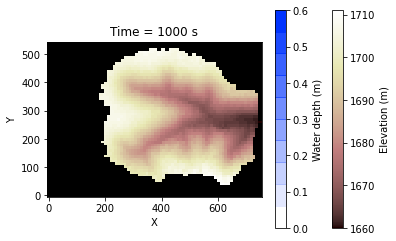

2.0% from total run time


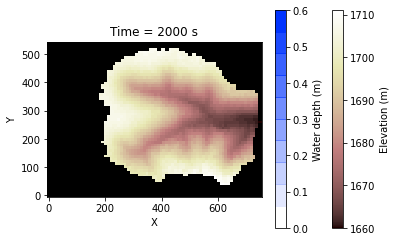

5.0% from total run time


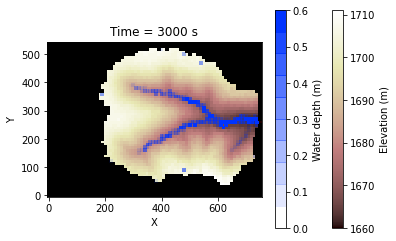

9.0% from total run time


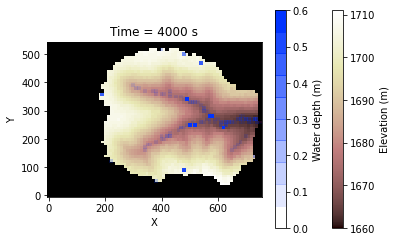

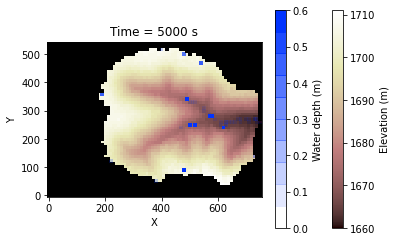

12.0% from total run time


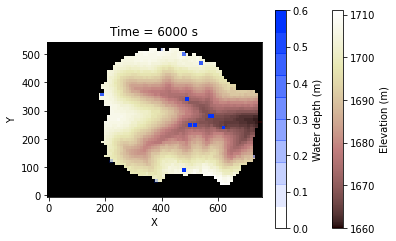

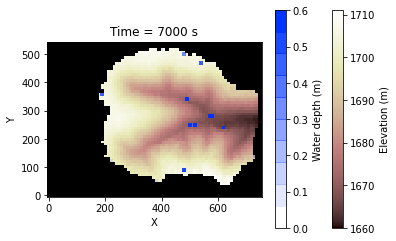

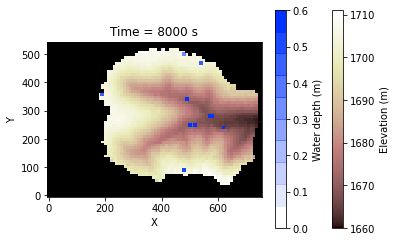

19.0% from total run time


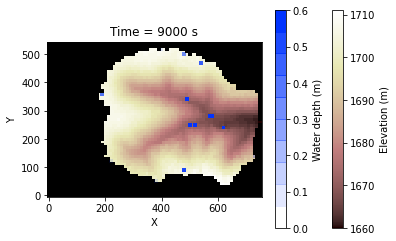

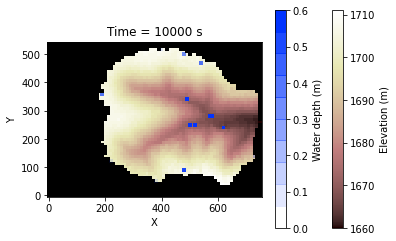

24.0% from total run time


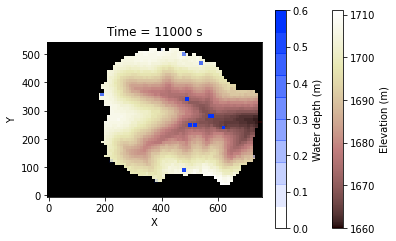

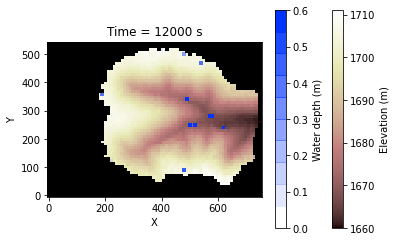

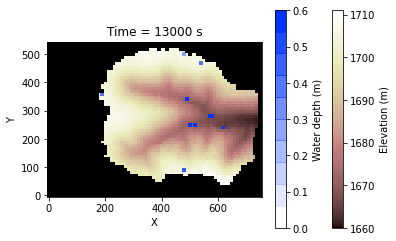

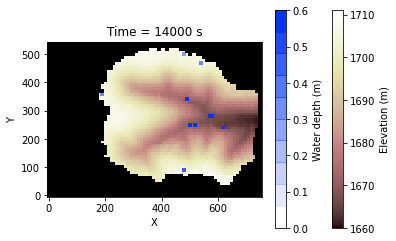

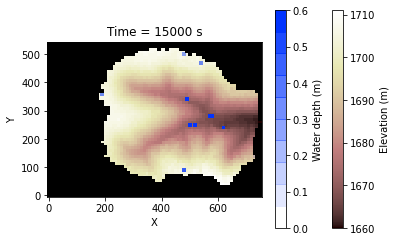

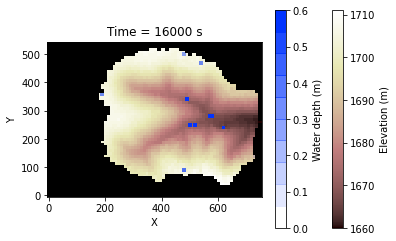

37.0% from total run time


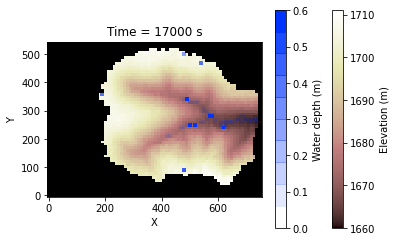

40.0% from total run time


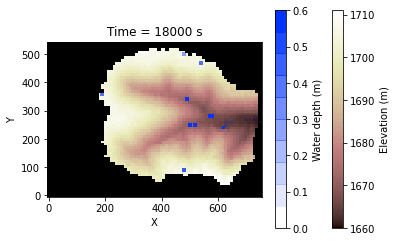

43.0% from total run time


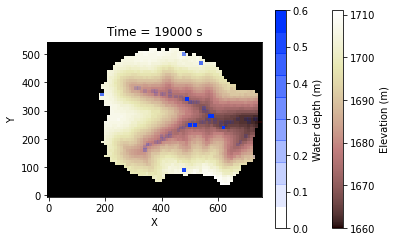

46.0% from total run time


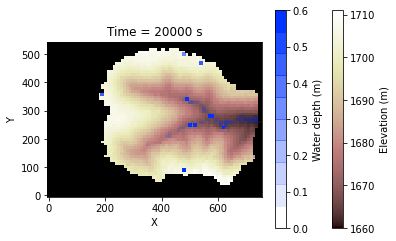

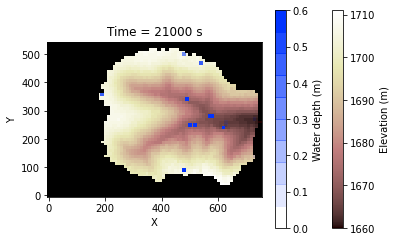

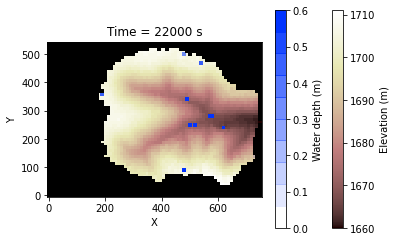

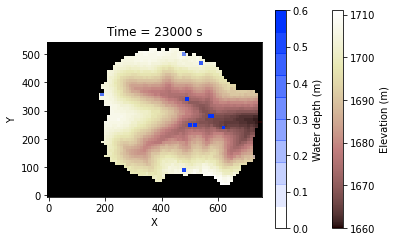

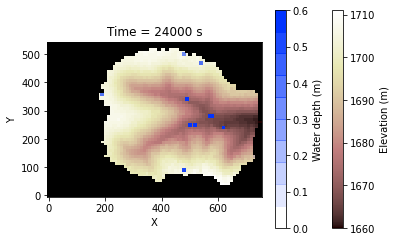

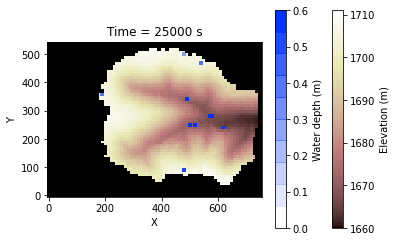

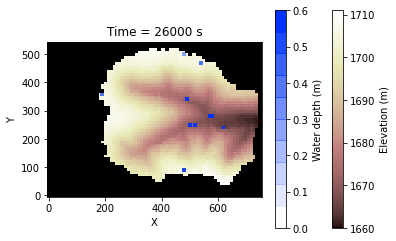

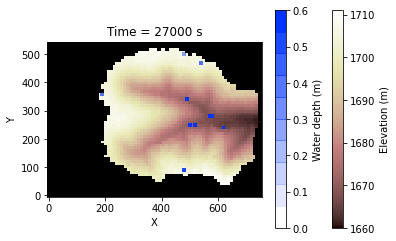

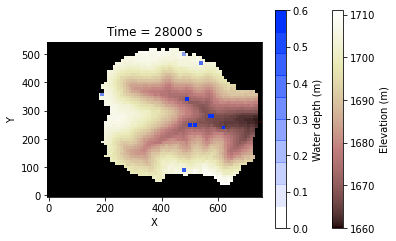

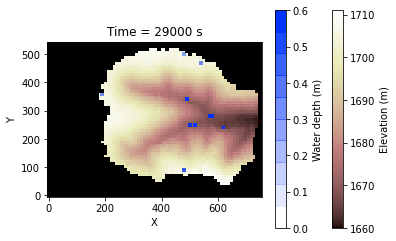

69.0% from total run time


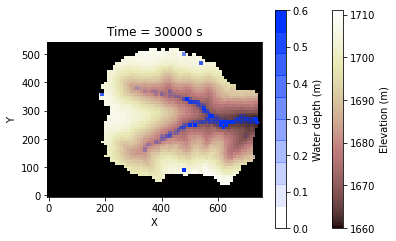

70.0% from total run time


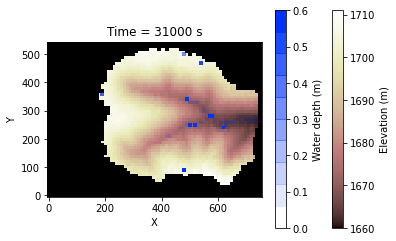

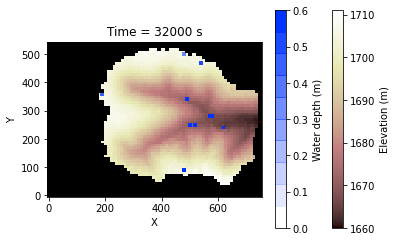

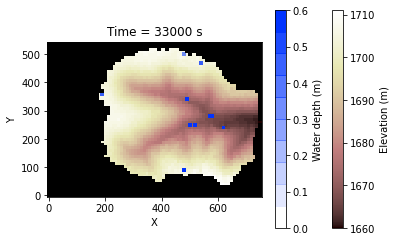

77.0% from total run time
77.0% from total run time
78.0% from total run time


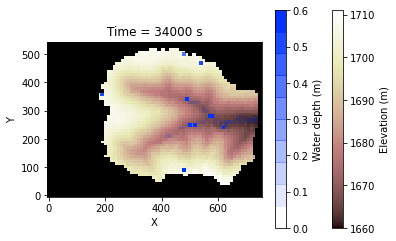

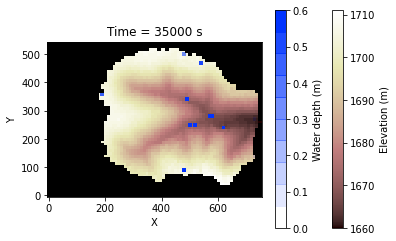

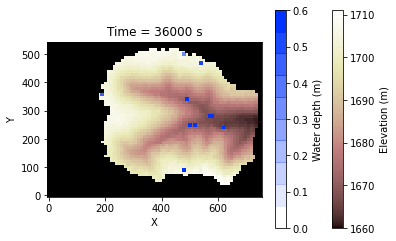

84.0% from total run time


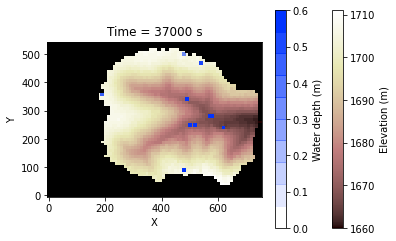

86.0% from total run time


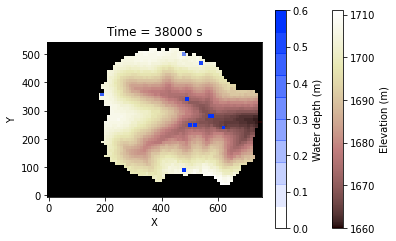

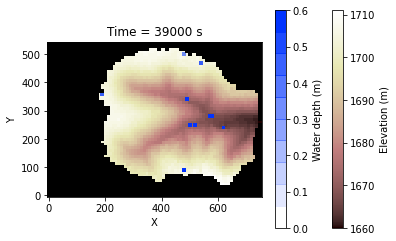

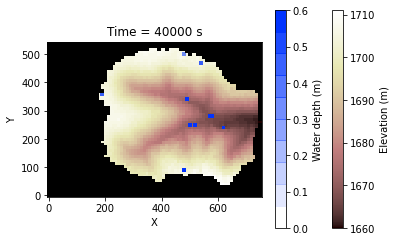

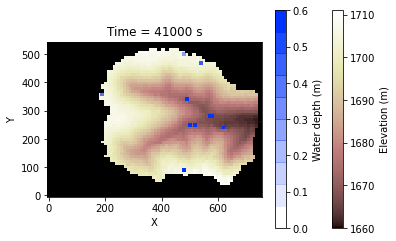

97.0% from total run time


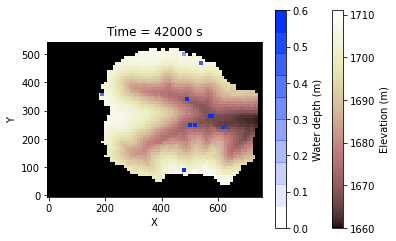

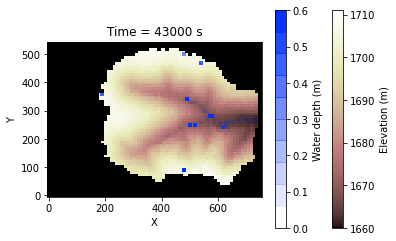

100.0% from total run time


In [135]:

## Main loop
for i in  range(0,len(storm_dts_min)):
    storm_t = storm_dts_min[i]
    interstorm_t = interstorm_dts_min[i]
    total_time_step = storm_t + interstorm_t
    storm_time = 0 
    print(str(np.round((elapsed_time/global_time)*100))+ '% from total run time')
    while storm_time < total_time_step:
        if storm_time < (total_time_step - interstorm_t):
            mg.at_node['surface_water__depth'] += (intensities[i]/(60))*0.001*10 ## meter in 10 minutes
            dt_overland = 10 
            SI.run_one_step(dt=dt_overland)
            SI_mean_vec.append(np.mean(mg.at_node['soil_water_infiltration__depth']))
            of.run_one_step(dt=dt_overland)
            elapsed_time += dt_overland
            outlet_times.append(elapsed_time) 
            outlet_depth.append(mg.at_node['surface_water__depth'][node_of_max_q])
            storm_time += dt_overland
        else:
            SI.run_one_step(dt=dt_overland)
            of.run_one_step(dt=dt_overland)
            SI_mean_vec.append(np.mean(mg.at_node['soil_water_infiltration__depth']))
            # Increased elapsed time
            elapsed_time += dt_overland
            outlet_times.append(elapsed_time) 
            outlet_depth.append(mg.at_node['surface_water__depth'][node_of_max_q])
            storm_time += dt_overland 
        if elapsed_time % 1000 == 0:    
            fig = plt.figure(1)
            imshow_grid(mg,'topographic__elevation',colorbar_label='Elevation (m)')
            imshow_grid(mg,'surface_water__depth',limits=(0,0.6),cmap=cmap,colorbar_label='Water depth (m)')
            plt.title(f'Time = {round(elapsed_time,1)} s')
            plt.show()

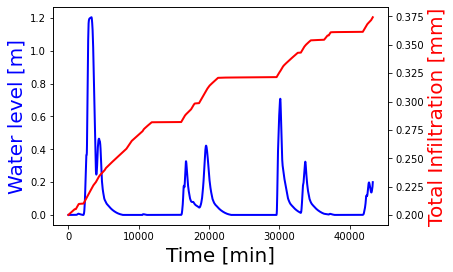

In [136]:

fig,ax = plt.subplots()
plt.plot(outlet_times,outlet_depth,color='blue',linewidth=2)
plt.ylabel('Water level [m]',color='blue',fontsize=20)
plt.xlabel('Time [min]',fontsize=20)
ax2=ax.twinx()
ax2.plot(outlet_times,SI_mean_vec,color="red",linewidth=2)
ax2.set_ylabel("Total Infiltration [mm]",color="red",fontsize=20)
plt.show()
